In [1]:
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import torch
import copy
import random

from torch import nn
from torch.optim import AdamW

# Deep SARSA

As we've seen before, SARSA refers to the method of temporal differences where an action $Q(s,a)$ is updated using an estimate of the discounted rewards $G_t \approx r_{t+1} \cdot Q_*(s',a')$. Where Q-values are stored in a table that maps state to actions to q-values. The thing with this approach is that what if we had continuous states or just too many that a q-table would just run short. 

One can "encode" the q-table's DNA inside something that tries to approximate the real Q function. So that, storage and estimates are more efficient. This approach uses Neural Networks as the Q function estimator $f(s|\theta)$ which returns the policy $\pi$ at state $s$ (the probabilities of doing each).

The Neural Network is trained using the temporal differences formula (the first one we presented) so estimate the loss. From that, the partial derivatives for each weight of the NN are obtained and updated using gradient descent.

## MSE

Neural networks use different metrics to calculate how good or bad the predictions are. In this case, we are going to use the MSE (Mean Squared Error) because we want to "amplify" the effect of large errors. MSE is defined as follows:

$$
    MSE = \begin{align*}
        \sum_{i=0}^{N}(y-\hat{y})^2 = \sum_{i=0}^{N}(G_{t+1}-Q(s,a|\theta))^2
        \end{align*}
$$

## Replay memory

With RL, we generate episodes with which experiences with the environment come. We have to choose how many of these experiences we want to pass into the NN at once to train it. This group of episodes to train the NN is called "Batch". This makes sure we've got enough experiences with the environment to work with and train the robust NN

The experiences are stored in what's called a "Buffer" and the data points follow SARSA: S, A, R, S' This way we can keep track of what happened at that moment in the past.

Also, buffers have a max_capacity which means that after that amount is reached, older experiences are dropped



## Target Neural Network

Deep SARSA makes use of two NN, one that's trained after N experiences have been made and the other that keeps a copy of the Q values K trainings in the past. This way, the NN that's being trained more often can use the target NN as a reference for convergion.

If we didn't use this approach, our NN would never converge because the target reference would always be moving as well.

This would give us another version of the RMSE formula:


$$
    MSE = \begin{align*}
        \sum_{i=0}^{N}(y-\hat{y})^2 = \sum_{i=0}^{N}(G_{t+1}-Q(s,a|\theta))^2 = \sum_{i=0}^{N}(r_t + Q_{t+1}(s',a'|\theta_{target})-Q(s,a | \theta))^2
        \end{align*}
$$

Where $\theta$ refers to the weights of the NN that's being trained often, and $\theta_{target}$ refers to the target NN's weights.

## Algorithm

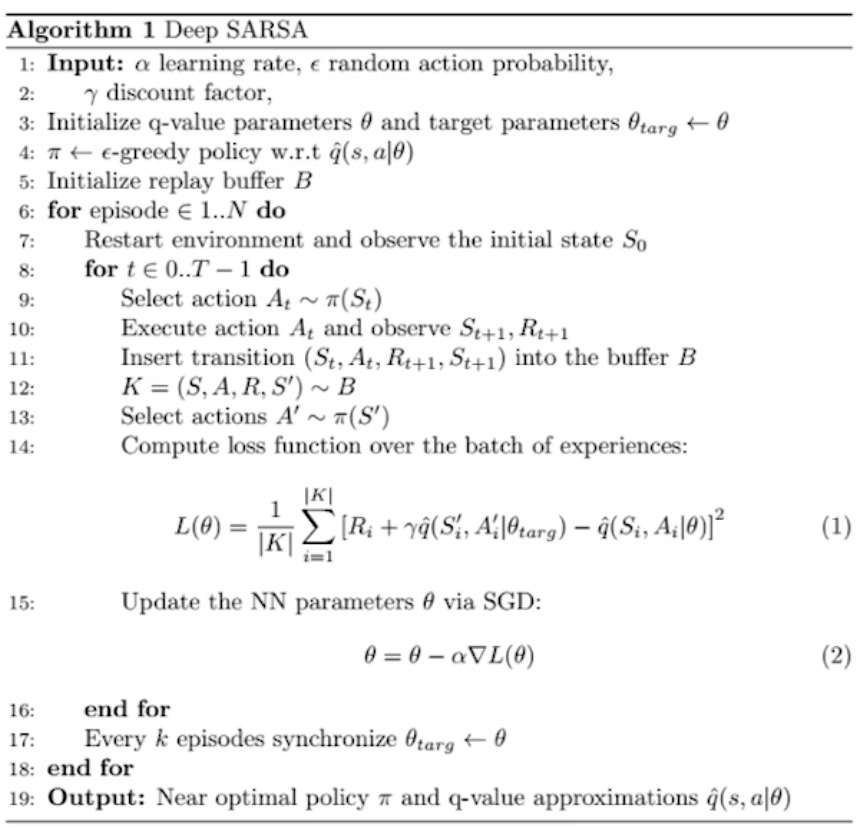

## Environment Preparation

In [2]:
env = gym.make("MountainCar-v0")
env.reset(seed=1999)
np.random.seed(1999)
torch.manual_seed(seed=1999)

In [3]:
state_dims = env.observation_space.shape[0]
num_actions = env.action_space.n
(state_dims, num_actions)

(2, 3)

In [4]:
class PreprocessEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
    
    def reset(self):
        state = self.env.reset()
        return torch.from_numpy(state[0]).unsqueeze(dim=0).float() # resulting tensor: [[0.5, 0.009]] with shape (1,2)

    def step(self, action):
        action  = action.item()
        next_state, reward, done, truncated, info = self.env.step(action)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float() # resulting tensor: [[0.5, 0.009]] with shape (1,2)
        reward = torch.tensor(reward).view(1,-1).float() # resulting tensor: [[0.12]] with shape (1,1)
        done = torch.tensor(done).view(1,-1) # resulting tensor: [[0]] with shape (1,1)
        return next_state, reward, done, info
    
class Replay:

    def __init__(self, max_size=10000):
        self.max_size = max_size
        self.buffer = []
        self.current_max_position = 0


    def append(self, step):
        if len(self.buffer) < self.max_size:
            self.buffer.append(None)
        
        self.buffer[self.current_max_position] = step
        self.current_max_position = (self.current_max_position + 1) % self.max_size

    
    def sample(self, batch_size):
        assert self.can_sample(batch_size)
 
        batch = random.sample(self.buffer, batch_size) # [([[S_1]],[[A_1]],[[R_1]],[[A_1']]),([[S_2]],[[A_2]],[[R_2]],[[A_2']])]
        batch = zip(*batch) # ([[S_1]],[[S_2]]),([[A_1]],[[A_2]]),([[R_1]],[[R_2]]),([[A_1']],[[A_2]]')
        # concat all the tuples along the same dimension sequentially [[[S_1, S_2]],[[A_1,A_2]],[[R_1,R_2]],[[A_1',A_2']]] 
        # with dim: N x D = 1 x 1+1 = (1,2) for each batch
        return [torch.cat(item) for item in batch]


    def can_sample(self, batch_size):
        return True if batch_size * 3 <= len(self.buffer) else False # can at least 3 batches be sampled
    
    def __len__(self):
        return len(self.buffer)
        

In [5]:
env = PreprocessEnv(env)
env

<PreprocessEnv<TimeLimit<OrderEnforcing<PassiveEnvChecker<MountainCarEnv<MountainCar-v0>>>>>>

## Pytorch Training Loop

Pytorch has different functionality that allows for training different models. This is a very standard one:
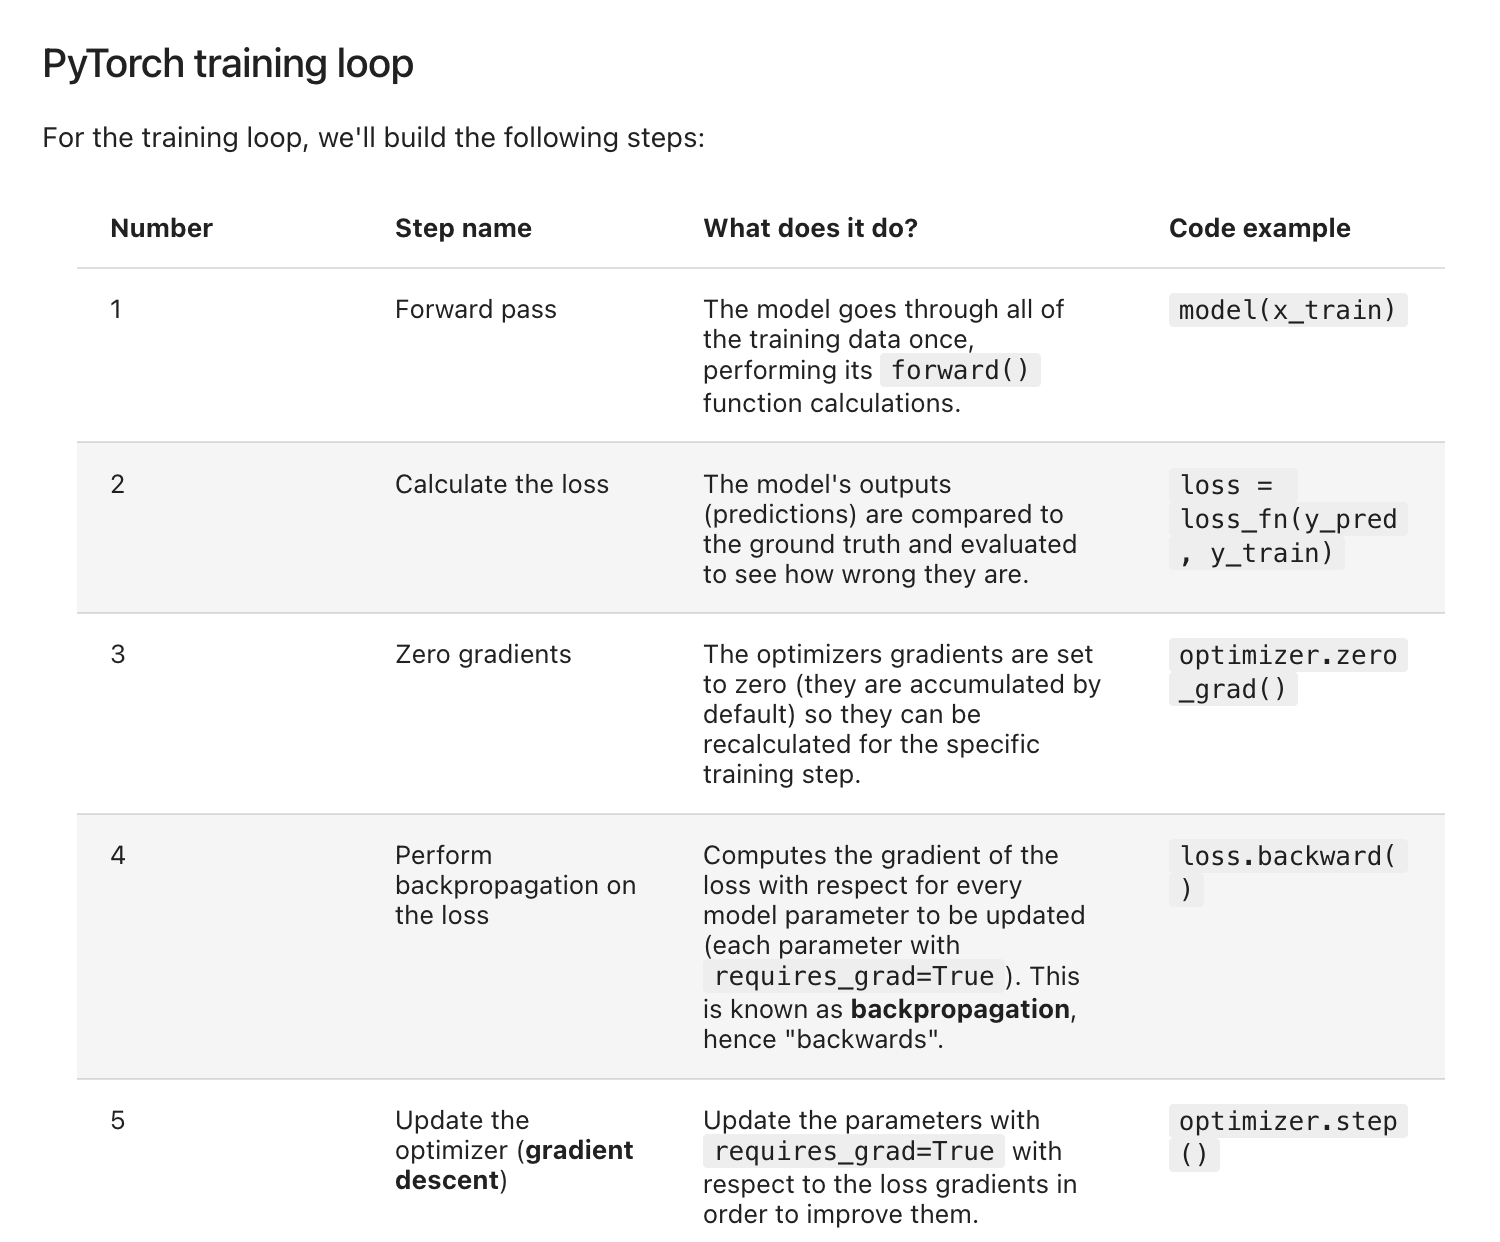
https://www.learnpytorch.io/01_pytorch_workflow/#creating-a-loss-function-and-optimizer-in-pytorch

In [6]:
q_nn = nn.Sequential(
     nn.Linear(state_dims, 128),
     nn.ReLU(),
     nn.Linear(128,64),
     nn.ReLU(),
     nn.Linear(64,num_actions)
)

target_q_nn = copy.deepcopy(q_nn)
target_q_nn = target_q_nn.eval() # turns on evaluation mode and turns off train mode
type(q_nn)

torch.nn.modules.container.Sequential

In [7]:
def policy(q_nn, state, epsilon):
    if np.random.random() < epsilon:
        # print(f"exploring for state...")
        return torch.randint(num_actions, (1,1)) # max random value is 1 (num actions is 2) and the return shape is: [[rand_int]]
    else:
        # print(f"exploting for state...")
        q_values_state = q_nn(state).detach() # Detach means the output won't be taken into account for grad calculations
        # in: [[0,4,0.3,0.3]] output: [[0]] => keep the same dimensions as input (2) and argmax along the 2 dim
        return torch.argmax(q_values_state, dim=-1, keepdim=True)

def deep_sarsa(env, q_nn, target_q_nn, episodes, alpha = 0.001, batch_size = 16, gamma = 0.99, epsilon = 0.99, epsilon_decay = 0.999):
    optim = AdamW(q_nn.parameters(), lr=alpha)
    replay_buffer = Replay()
    stats = {
        'MSE Loss':[],
        'Returns':[]
    }
    for episode in range(episodes):
        print(f"------- EPISODE {episode} -------")
        state = env.reset()
        done = False
        ep_return = 0.0
        while not done:
            action = policy(q_nn, state, epsilon)
            next_state, reward, done, _ = env.step(action)
            replay_buffer.append((state, action, reward, done, next_state))

            if replay_buffer.can_sample(batch_size):
                state_b, action_b, reward_b, done_b, next_state_b = replay_buffer.sample(batch_size)
                # gather along the row [q_1, q_2, q_3] for each observation [[0],[1],[0]] dim: 1
                # which means: return first q-value for first observation, second q-value for second observation 
                # and first q-value for last observation
                qsa_b = q_nn(state_b).gather(1, action_b) 
                next_action_b = policy(q_nn, next_state_b, epsilon)
                next_qsa_b = target_q_nn(next_state_b).gather(1, next_action_b)
                target_b = reward_b + gamma * next_qsa_b * (not done_b)

                # loss has to be calculated as this is the base of the gradients
                # for updating the parameters (weights and biases)
                loss = F.mse_loss(qsa_b, target_b)
                # resets the optimizer gradients (they are accumulated by default)
                # so by restarting them, we can get the calculations for the
                # current iteration
                q_nn.zero_grad()
                # backpropagation is performed on the loss after it has been calculated
                loss.backward()
                # with backpropagation, we get the new parameters' partial derivatives estimates
                # now, the optimizer has to decide in which direction to move in
                optim.step()

                # By the way, the tensors for the loss, model's parameters and optimizer are connected
                # through what's known as autograd which, in simpler words, all it does is to keep track
                # of every single tensor involved in the calculations for the NN. It doesn't look like
                # they are connected, but they are

                stats["MSE Loss"].append(loss.item())
                # print(f"\t------- STATS -------")
                # print(f"\tMSE: {loss.item()}")


            state = next_state
            ep_return += reward.item()
            epsilon *= epsilon_decay
        
        stats['Returns'].append(ep_return)

        if episode % 16:
            target_q_nn.load_state_dict(q_nn.state_dict())
    
    return stats

In [8]:
stats = deep_sarsa(env, q_nn, target_q_nn, 100, alpha=0.01)

------- EPISODE 0 -------


/Users/edselmanuellauchodimeo/Documents/vscode/RL_testing/policy_iteration/.venv/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


------- EPISODE 1 -------
------- EPISODE 2 -------
------- EPISODE 3 -------
------- EPISODE 4 -------
------- EPISODE 5 -------
------- EPISODE 6 -------
------- EPISODE 7 -------
------- EPISODE 8 -------
------- EPISODE 9 -------
------- EPISODE 10 -------
------- EPISODE 11 -------
------- EPISODE 12 -------
------- EPISODE 13 -------
------- EPISODE 14 -------
------- EPISODE 15 -------
------- EPISODE 16 -------
------- EPISODE 17 -------
------- EPISODE 18 -------
------- EPISODE 19 -------
------- EPISODE 20 -------
------- EPISODE 21 -------
------- EPISODE 22 -------
------- EPISODE 23 -------
------- EPISODE 24 -------
------- EPISODE 25 -------
------- EPISODE 26 -------
------- EPISODE 27 -------
------- EPISODE 28 -------
------- EPISODE 29 -------
------- EPISODE 30 -------
------- EPISODE 31 -------
------- EPISODE 32 -------
------- EPISODE 33 -------
------- EPISODE 34 -------
------- EPISODE 35 -------
------- EPISODE 36 -------
------- EPISODE 37 -------
------- EP

Text(0, 0.5, 'MSE')

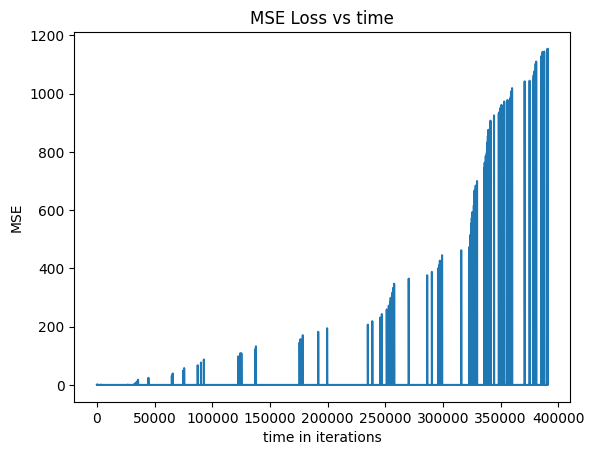

In [9]:
plt.plot(range(len(stats['MSE Loss'])),stats['MSE Loss'])
plt.title("MSE Loss vs time")
plt.xlabel("time in iterations")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

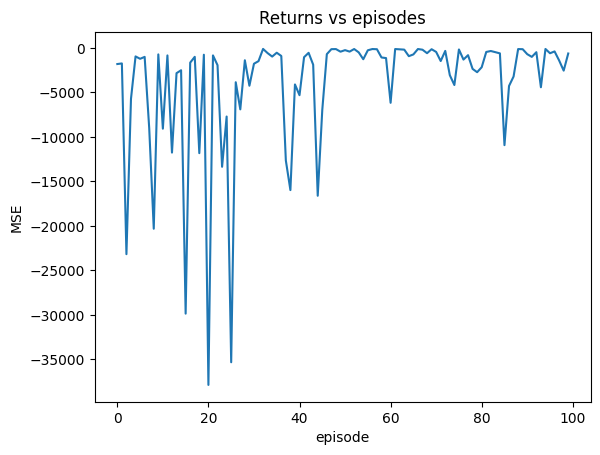

In [10]:
plt.plot(range(len(stats['Returns'])),stats['Returns'])
plt.title("Returns vs episodes")
plt.xlabel("episode")
plt.ylabel("MSE")